In [1]:
%load_ext autoreload
%autoreload 2

import cryogrid_pytools as cgt
import pandas as pd

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

In [2]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/output-failed-71_of_90_run/strat_107809_20000101.mat'
cgt.read_OUT_regridded_FCI2_file(fname, deepest_point=-5)

<xarray.Dataset> Size: 4MB
Dimensions:       (time: 1461, depth: 151)
Coordinates:
  * time          (time) datetime64[ns] 12kB 1999-01-01 ... 2000-01-01
  * depth         (depth) float64 1kB 2.5 2.45 2.4 2.35 ... -4.9 -4.95 -5.0
Data variables:
    T             (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    water         (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    ice           (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    class_number  (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    FCI           (time, depth) float32 882kB dask.array<chunksize=(1461, 151), meta=np.ndarray>
    elevation     (depth) float64 1kB dask.array<chunksize=(151,), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/ou...

In [4]:
fname = "/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/spatial_simulations/Tronfjell_spatial3/Tronfjell_spatial3_*_201*.mat"
out = cgt.read_OUT_regridded_FCI2_clusters(fname, deepest_point=-5)
out

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    7.0s finished


<xarray.Dataset> Size: 6GB
Dimensions:       (gridcell: 120, time: 14618, depth: 131)
Coordinates:
  * gridcell      (gridcell) int64 960B 56 57 237 347 ... 26404 26408 26504
  * time          (time) datetime64[ns] 117kB 2009-09-01 ... 2019-09-01
  * depth         (depth) float64 1kB 1.5 1.45 1.4 1.35 ... -4.9 -4.95 -5.0
Data variables:
    T             (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    water         (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    ice           (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    class_number  (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    FCI           (gridcell, depth, time) float32 919MB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>
    elevation     (gridcell, depth, time) float64 2GB dask.array<chunksize=(1, 131, 1461), meta=np.ndarray>

# Reading struct files from MATLAB

Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:


```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [6]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/spatial_simulations/run_spatial_statvar.mat'
spatial = cgt.read_mat_struct_as_dataset(fname, index=['Y', 'X'])
spatial

<xarray.Dataset> Size: 1MB
Dimensions:         (Y: 178, X: 149)
Coordinates:
  * Y               (Y) int32 712B 6898675 6898700 6898725 ... 6903075 6903100
  * X               (X) int32 596B 274107 274132 274157 ... 277757 277782 277807
Data variables:
    latitude        (Y, X) float64 212kB 62.15 62.15 62.15 ... 62.19 62.19 62.19
    longitude       (Y, X) float64 212kB 10.66 10.66 10.66 ... 10.73 10.73 10.73
    key             (Y, X) uint16 53kB 1 179 357 535 ... 25988 26166 26344 26522
    mask            (Y, X) uint8 27kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    altitude        (Y, X) float64 212kB 944.8 952.9 959.9 ... 848.4 843.0 838.0
    slope_angle     (Y, X) float64 212kB 23.31 21.27 17.86 ... 13.59 13.29 12.32
    aspect          (Y, X) float64 212kB 312.4 314.1 317.5 ... 118.9 122.9 122.0
    skyview_factor  (Y, X) float64 212kB 0.9592 0.9659 0.9759 ... 0.9866 0.9885
    horizon_bins    (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    horizon_angles  (Y, X) uint8 27kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

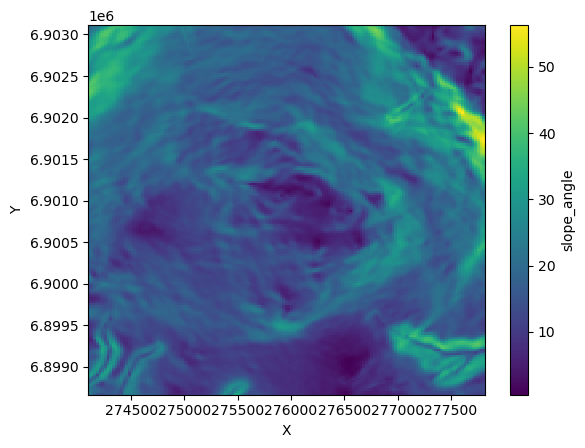

In [5]:
spatial.slope_angle.plot()

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [6]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat.xlsx'
config = cgt.CryoGridConfigExcel(fname, checks=False)

forcing_path = config.get_forcing_path()
print(forcing_path)

2024-11-14 11:09:59.174 | INFO     | cryogrid_pytools.excel_config:_get_root_path:45 - Found root path: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov


2024-11-14 11:09:59.352 | SUCCESS  | cryogrid_pytools.excel_config:__init__:24 - Loaded CryoGrid Excel configuration file: /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/runs/strat/strat.xlsx
2024-11-14 11:09:59.369 | INFO     | cryogrid_pytools.excel_config:__init__:37 - Start and end times: 2000-01-01 - 2002-12-31


/Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-era5-1970_2020.mat


# Reading ERA5 forcing data

In [7]:
fname = '../../SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogrid-pamir_abramov-era5-1970_2020.mat'
ds = cgt.forcing.read_mat_ear5(fname)
ds

<xarray.Dataset> Size: 459MB
Dimensions:  (lon: 3, lat: 2, level: 11, time: 149024)
Coordinates:
  * lon      (lon) float32 12B 71.5 71.75 72.0
  * lat      (lat) float32 8B 39.75 39.5
  * level    (level) int64 88B 50000 55000 60000 65000 ... 90000 95000 100000
  * time     (time) float64 1MB 7.195e+05 7.195e+05 ... 7.382e+05 7.382e+05
Data variables: (12/21)
    Zs       (lat, lon) float64 48B 3.656e+03 3.679e+03 ... 3.324e+03 3.203e+03
    u10      (time, lat, lon) float64 7MB -0.3 0.53 -0.07 ... 0.19 0.43 -0.21
    v10      (time, lat, lon) float64 7MB 2.14 2.2 1.71 ... -1.45 -1.01 -0.81
    ps       (time, lat, lon) float64 7MB 6.48e+04 6.46e+04 ... 6.8e+04 6.91e+04
    Td2      (time, lat, lon) float64 7MB -15.72 -16.07 -17.65 ... -33.16 -34.75
    T2       (time, lat, lon) float64 7MB -12.81 -13.12 -13.67 ... -28.04 -26.75
    ...       ...
    wind_sf  float64 8B 0.01
    q_sf     float64 8B 1e-06
    ps_sf    float64 8B 100.0
    rad_sf   float64 8B 0.1
    T_sf     float64 8B 0.01
    P_sf     float64 8B 0.01
Attributes:
    info:     Data read in from CryoGrid ERA5 forcing file. Data has been sca...
    source:   /Users/luke/SDSC/CryoGrid/cryogrid-pamir/abramov/forcing/cryogr...

In [ ]:
fname = '/Users/luke/SDSC/CryoGrid/cryogrid-ITCH-ML/data/Tronfjell_summit.mat'
forcing = cgt.read_mat_struct_as_dataset(fname, index='timeForcing', index_is_datenum=1)
forcing

<xarray.Dataset> Size: 28MB
Dimensions:       (timeForcing: 236688)
Coordinates:
  * timeForcing   (timeForcing) datetime64[ns] 2MB 1940-01-01 ... 2020-12-31T...
Data variables: (12/14)
    Tair          (timeForcing) float64 2MB -16.73 -14.74 ... -10.58 -10.85
    q             (timeForcing) float64 2MB 0.001008 0.001211 ... 0.001741
    wind          (timeForcing) float64 2MB 4.6 5.266 6.221 ... 2.616 1.707
    Sin_dir       (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin_dif       (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin           (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...            ...
    p             (timeForcing) float64 2MB 8.247e+04 8.256e+04 ... 8.175e+04
    precip        (timeForcing) float64 2MB 0.0 0.0 0.0 ... 2.944 3.937 0.6699
    snowfall      (timeForcing) float64 2MB 0.0 0.0 0.0 ... 8.819 11.79 2.007
    rainfall      (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    azimuth       (timeForcing) float64 2MB 165.6 110.7 70.36 ... 272.7 227.6
    sunElevation  (timeForcing) float64 2MB -50.35 -36.42 ... -24.8 -44.19